In [1]:
import tensorflow as tf
import pandas as pd
import os, time, itertools, imageio, pickle, random
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import one_hot, resize_to_ori_calMRE, resize_to_ori
# from Kmeans_sampling import Kmeans

tf.reset_default_graph() 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # select GPU

C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\pyth

In [2]:
folder = 'election_GAN/'
gen_results = 'generated_results/'

model = 'model_'+'.ckpt'

if not os.path.isdir(folder):
    os.mkdir(folder)
    
if not os.path.isdir(folder + gen_results):
    os.mkdir(folder + gen_results)

# save ckpt
saver_path = os.path.join(folder, model)

# read ckpt
restore_path = os.path.join(folder)

# save generated data
generated_path = os.path.join(folder + gen_results)

In [3]:
img_width = 30
img_height = 24

data_alt3_all = pd.read_csv('./data/netflix_data_3alt_resize.csv')
data_alt3 = data_alt3_all.iloc[:1000,1:].values
data_alt3_val = data_alt3_all.iloc[1000:2000,1:].values

data_alt3 = data_alt3.reshape([-1, img_height, img_width])
print(data_alt3.shape)

##################################
data_alt4_all = pd.read_csv('./data/netflix_data_4alt_resize.csv')
data_alt4 = data_alt4_all.iloc[:1000,1:].values
data_alt4_val = data_alt4_all.iloc[1000:2000,1:].values

data_alt4 = data_alt4.reshape([-1, img_height, img_width])
print(data_alt4.shape)

data_alt_3_4 = np.concatenate( (data_alt3, data_alt4), axis = 0)
print(data_alt_3_4.shape)

(1000, 24, 30)
(1000, 24, 30)
(2000, 24, 30)


In [4]:
label_alt3 = np.zeros([data_alt3.shape[0]])
label_alt4 = np.zeros([data_alt4.shape[0]]) + 1
label_alt_3_4 = np.concatenate( (label_alt3,label_alt4), axis = 0)

label_alt_onehot = one_hot(label_alt_3_4, 1 + 1)   
print(label_alt_onehot.shape)

(2000, 2)


In [5]:
img_size = np.math.factorial(6)
img_width = 30
img_height = 24
ori_size = np.math.factorial(3)

data_alt3_ori = resize_to_ori_calMRE(data_alt3, img_size, img_width, img_height, ori_size)
data_alt3_val_ori = resize_to_ori_calMRE(data_alt3_val, img_size, img_width, img_height, ori_size)
print(data_alt3_ori.shape)
print(data_alt3_val_ori.shape)

(1000, 6)
(1000, 6)


In [6]:
img_size = np.math.factorial(6)
img_width = 30
img_height = 24
ori_size = np.math.factorial(4)

data_alt4_ori = resize_to_ori_calMRE(data_alt4, img_size, img_width, img_height, ori_size)
data_alt4_val_ori = resize_to_ori_calMRE(data_alt4_val, img_size, img_width, img_height, ori_size)
print(data_alt4_ori.shape)
print(data_alt4_val_ori.shape)

(1000, 24)
(1000, 24)


In [7]:
delta3_RE = []
delta4_RE = []
for i in range(len(data_alt3_ori)):
    delta3_set = []
    delta4_set = []
    for j in range(len(data_alt3_val_ori)):
        delta3 = np.sum(np.square(data_alt3_ori[i] - data_alt3_val_ori[j]))
        delta4 = np.sum(np.square(data_alt4_ori[i] - data_alt4_val_ori[j]))        
        delta3_set.append(delta3)
        delta4_set.append(delta4)
    delta3_RE.append(min(delta3_set))
    delta4_RE.append(min(delta4_set))
    
MREvalue_val_alt3 = np.mean(delta3_RE) # train and val 
MREvalue_val_alt4 = np.mean(delta4_RE) # trani and val

In [10]:
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.cla()
# ax.imshow(np.reshape(data_alt3[2], (data_alt3.shape[1], data_alt3.shape[2])), cmap='gray')

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.cla()
# ax.imshow(np.reshape(data_alt4[99], (data_alt3.shape[1], data_alt3.shape[2])), cmap='gray')

In [11]:
np.random.seed(0)
np.random.shuffle(data_alt_3_4)

np.random.seed(0)
np.random.shuffle(label_alt_onehot)

In [13]:
class election_GAN(object):
    def __init__(self,
                num_samples = None,
                dim_height = None,
                dim_width = None,
                dim_z = None,
                num_class = None,
                batch_size = None,
                _reuse = None,
                MemorizationPenalty_start = None,
                ):
        
        # Definition Params:
        self.num_samples = num_samples  
        self.dim_height = dim_height    
        self.dim_width = dim_width  
        self.dim_z = dim_z    
        self.num_class = num_class      
        self.batch_size = batch_size 
        self.MemorizationPenalty_start = MemorizationPenalty_start

        # Define Network Input:
        self.X = tf.placeholder(tf.float32, shape=(None, self.dim_height, self.dim_width, 1))
        self.Z = tf.placeholder(tf.float32, shape=(None, 1, 1, self.dim_z))
        self.Y_label = tf.placeholder(tf.float32, shape=(None, 1, 1, self.num_class))
        self.Y_fill = tf.placeholder(tf.float32, shape=(None, self.dim_height, self.dim_width, self.num_class))
        self.isTrain = tf.placeholder(dtype=tf.bool)
        self.keep_prob_feed = tf.placeholder(tf.float32)
        self.global_step = tf.Variable(0, trainable = False)
        self.MREvalue_val_alt3 = tf.placeholder(tf.float32)
        self.MREvalue_val_alt4 = tf.placeholder(tf.float32)
        self.MRE_val_index = tf.placeholder(tf.float32, shape=(None, 1))
        self.MRE_alt3_ori = tf.placeholder(tf.float32, shape=(None, 6))
        self.MRE_alt4_ori = tf.placeholder(tf.float32, shape=(None, 24))
        self.MemorizationPenalty_number = tf.Variable(0, trainable = False)
        self.n_critic = tf.Variable(0, trainable = False)
        
        # Network:
        self._GEN(self.Z, self.Y_label, self.keep_prob_feed, self.isTrain, _reuse)
        
        self._DIS(self.X, self.Y_fill, self.keep_prob_feed, self.isTrain, _reuse)
            
        with tf.variable_scope('object_cost_function', reuse=tf.AUTO_REUSE):
            self._object_cost_function() 
        
    def _GEN(self, Z, Y_label, keep_prob_feed, isTrain=True, _reuse=False):

        with tf.variable_scope("GEN", reuse=_reuse):
            dim = 128

            # concat layer
            Z_ = tf.concat([Z, Y_label], 3)  #(batch_szie, 1, 1, dim_z + num_class)
            Z_ = tf.reshape(Z_, (-1, self.dim_z + self.num_class))        

            # FCN 
            hidden = tf.layers.dense(Z_, units = 2*2*3*dim)
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)
            hidden = tf.reshape(hidden, (-1, 2, 2, 3*dim)) 

            # CNN 1 
            hidden = tf.layers.conv2d_transpose(hidden, 2*dim, [3, 3], strides=(1, 2), padding='valid')
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)

            # CNN 2 
            hidden = tf.layers.conv2d_transpose(hidden, 1*dim, [3, 3], strides=(3, 3), padding='same')
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)     

            # CNN 3 
            hidden = tf.layers.conv2d_transpose(hidden, 1, [3, 3], strides=(2, 2), padding='same')         
            output = hidden

            return output     
    
    def _DIS(self, X, Y_fill, keep_prob_feed, isTrain=True, _reuse=False):

        with tf.variable_scope("DIS", reuse=_reuse):
            dim = 128
            leak = 0.2
            # concat layer
            X_ = tf.concat([X, Y_fill], 3)  #(batch_size, dim_height, dim_width, channel + num_class)

            # CNN 1 
            hidden = tf.layers.conv2d(X_, 1*dim, [4, 5], strides=(2, 2), padding='same', use_bias=False)
            hidden = ((0.5 * (1 + leak)) * hidden) + ((0.5 * (1 - leak)) * tf.abs(hidden)) #lrelu

            # CNN 2 
            hidden = tf.layers.conv2d(hidden, 2*dim, [4, 5], strides=(2, 2), padding='same', use_bias=False)
            hidden = ((0.5 * (1 + leak)) * hidden) + ((0.5 * (1 - leak)) * tf.abs(hidden)) #lrelu

            # CNN 3
            hidden = tf.layers.conv2d(hidden, 2*dim, [4, 5], strides=(2, 2), padding='same', use_bias=False)
            hidden = ((0.5 * (1 + leak)) * hidden) + ((0.5 * (1 - leak)) * tf.abs(hidden)) #lrelu

            # Flatten layer
            hidden = tf.layers.flatten(hidden)        
            score = tf.layers.dense(hidden, units = 1)
            score = tf.reshape(score, (-1, 1))          

            return score
    
                        
    def _resize_fault3(self, x, img_size = np.math.factorial(6), ori_size = np.math.factorial(3)):  
        x = tf.reshape(x, (self.dim_height*self.dim_width,))  
        cell_size = int(img_size//ori_size)
        count = tf.constant(0) 
        num_iter = tf.constant(int(x.shape[0] // cell_size))  
        
        dat = tf.Variable([])
        dat_ = tf.zeros([6,])
        def cond(count, num_iter, dat):
            return  count < num_iter
        def body(count, num_iter, dat):
            k = x[(count)*cell_size:(count+1)*cell_size]
            res = tf.reduce_mean(k)
            dat = tf.concat([dat, [res]], 0)
    
            count = count + 1
            return count, num_iter, dat
        count, num_iter, dat = tf.while_loop(cond, body, [count, num_iter, dat]
        , shape_invariants=[count.get_shape(), num_iter.get_shape(), tf.TensorShape([None,])])      

        dat_ = dat + dat_
        
        return tf.reshape(dat_, (1,6))
    
    def _resize_fault4(self, x, img_size = np.math.factorial(6), ori_size = np.math.factorial(4)):
        x = tf.reshape(x, (self.dim_height*self.dim_width,))  
        cell_size = int(img_size//ori_size)
        count = tf.constant(0) 
        num_iter = tf.constant(int(x.shape[0] // cell_size))  
        
        dat = tf.Variable([])
        dat_ = tf.zeros([24,])
        def cond(count, num_iter, dat):
            return  count < num_iter
        def body(count, num_iter, dat):
            k = x[(count)*cell_size:(count+1)*cell_size]
            res = tf.reduce_mean(k)
            dat = tf.concat([dat, [res]], 0)

            count = count + 1
            return count, num_iter, dat
        count, num_iter, dat = tf.while_loop(cond, body, [count, num_iter, dat]
        , shape_invariants=[count.get_shape(), num_iter.get_shape(), tf.TensorShape([None,])])         
        
        dat_ = dat + dat_

        return tf.reshape(dat_, (1,24))    
    
    def _cal_MRE_and_delta_sum1(self, x):
        
        with tf.variable_scope("cal_MRE_and_delta_sum1", reuse=False):
            self.fake_output_mre = tf.reshape(x, (-1, self.dim_height*self.dim_width)) 

            ''' pick alt3 '''
            count = tf.Variable(0, name='count3') 
            num_iter = tf.constant(self.batch_size, name='num_iter3') 
            resize_gen = tf.zeros([1,6], name='resize_gen3')
            def cond_1(count, num_iter, resize_gen):
                return count < num_iter
            def body_1(count, num_iter, resize_gen):
                resize3 = lambda: self._resize_fault3(self.fake_output_mre[count])
                resize4 = lambda: 100 * tf.constant([1]*6, shape=[1,6], dtype=tf.float32)
                resize_result = tf.cond(tf.reduce_mean(self.MRE_val_index[count]) > 0, resize4, resize3)
                resize_gen = tf.concat([resize_gen, resize_result], 0)

                count = count + 1
                return count, num_iter, resize_gen
            count, num_iter, resize_gen = tf.while_loop(cond_1, body_1, [count, num_iter, resize_gen]
                , shape_invariants=[count.get_shape(), num_iter.get_shape(), tf.TensorShape([None, None])])     
            resize_gen_alt3 = resize_gen[1:, :]


            ''' pick alt4 '''
            count = tf.constant(0) 
            num_iter = tf.constant(self.batch_size)  
            resize_gen = tf.zeros([1,24])
            def cond_2(count, num_iter, resize_gen):
                return  count < num_iter
            def body_2(count, num_iter, resize_gen):
                resize3 = lambda: 100 * tf.constant([1]*24, shape=[1,24], dtype=tf.float32)
                resize4 = lambda: self._resize_fault4(self.fake_output_mre[count])
                resize_result = tf.cond(tf.reduce_mean(self.MRE_val_index[count]) > 0, resize4, resize3)
                resize_gen = tf.concat([resize_gen, resize_result], 0)

                count = count + 1
                return count, num_iter, resize_gen
            count, num_iter, resize_gen = tf.while_loop(cond_2, body_2, [count, num_iter, resize_gen]
                , shape_invariants=[count.get_shape(), num_iter.get_shape(), tf.TensorShape([None, None])])     
            resize_gen_alt4 = resize_gen[1:, :]

            ''' calculate MRE '''
            count_out = tf.constant(0) 
            num_iter_out = tf.constant(int(self.num_samples//2))  
            delta3_RE = tf.Variable([])
            delta4_RE = tf.Variable([])

            def cond_3(count_out, num_iter_out, delta3_RE, delta4_RE):
                return  count_out < num_iter_out
            def body_3(count_out, num_iter_out, delta3_RE, delta4_RE):

                delta3_set = tf.Variable([])
                delta4_set = tf.Variable([])

                count_in = tf.constant(0) 
                num_iter_in = tf.constant(self.batch_size)              
                def cond_4(count_in, num_iter_in, delta3_set, delta4_set):
                    return  count_in < num_iter_in
                def body_4(count_in, num_iter_in, delta3_set, delta4_set):
                    delta3 = tf.reduce_sum(tf.square(tf.subtract(self.MRE_alt3_ori[count_out], resize_gen_alt3[count_in])))
                    delta4 = tf.reduce_sum(tf.square(tf.subtract(self.MRE_alt4_ori[count_out], resize_gen_alt4[count_in])))
                    delta3_set = tf.concat([delta3_set, [delta3]], 0)
                    delta4_set = tf.concat([delta4_set, [delta4]], 0)

                    count_in = count_in + 1
                    return count_in, num_iter_in, delta3_set, delta4_set
                count_in, num_iter_in, delta3_set, delta4_set = tf.while_loop(cond_4, body_4, 
                    [count_in, num_iter_in, delta3_set, delta4_set]
                    , shape_invariants = [count_in.get_shape(), num_iter_in.get_shape(),
                                          tf.TensorShape([None,]), tf.TensorShape([None,]) ]) 

                delta3_RE = tf.concat([delta3_RE, [tf.reduce_min(tf.stack(delta3_set))]], 0)
                delta4_RE = tf.concat([delta4_RE, [tf.reduce_min(tf.stack(delta4_set))]], 0)            

                count_out = count_out + 1
                return count_out, num_iter_out, delta3_RE, delta4_RE
            count_out, num_iter_out, delta3_RE, delta4_RE = tf.while_loop(cond_3, body_3, 
                [count_out, num_iter_out, delta3_RE, delta4_RE]
                , shape_invariants=[count_out.get_shape(), num_iter_out.get_shape()
                                    , tf.TensorShape([None,]), tf.TensorShape([None,]) ])     

            MRE3 = tf.reduce_mean(delta3_RE)
            MRE4 = tf.reduce_mean(delta4_RE)

            MRE3_norm = tf.div(tf.abs(tf.subtract(self.MREvalue_val_alt3, MRE3)), self.MREvalue_val_alt3)
            MRE4_norm = tf.div(tf.abs(tf.subtract(self.MREvalue_val_alt4, MRE4)), self.MREvalue_val_alt4)             

            '''restrict all ranking sum to 1'''
            with tf.variable_scope("sum1", reuse=False):
                count_sum1 = tf.constant(0) 
                num_iter_sum1 = tf.constant(self.batch_size)  
                
                resize_gen_sum1 = tf.Variable([])
                def cond_sum1(count_sum1, num_iter_sum1, resize_gen_sum1):
                    return count_sum1 < num_iter_sum1
                def body_sum1(count_sum1, num_iter_sum1, resize_gen_sum1):
                    resize3 = lambda: tf.reduce_sum(self._resize_fault3(self.fake_output_mre[count_sum1]))
                    resize4 = lambda: tf.reduce_sum(self._resize_fault4(self.fake_output_mre[count_sum1]))
                    resize_result = tf.cond(tf.reduce_mean(self.MRE_val_index[count_sum1]) > 0, resize4, resize3)
                    resize_gen_sum1 = tf.concat([resize_gen_sum1, [resize_result]], 0)

                    count_sum1 = count_sum1 + 1
                    return count_sum1, num_iter_sum1, resize_gen_sum1
                count_sum1, num_iter_sum1, resize_gen_sum1 = tf.while_loop(cond_sum1, body_sum1,
                    [count_sum1, num_iter_sum1, resize_gen_sum1]
                    , shape_invariants=[count_sum1.get_shape(), num_iter_sum1.get_shape(), tf.TensorShape([None,])])     

                sum1 = tf.constant([1]*self.batch_size, shape=[self.batch_size,], dtype=tf.float32)
                rank_delta_sum1 = tf.reduce_sum(tf.abs(tf.subtract(resize_gen_sum1, sum1)))        

                rank_delta_sum1_ = tf.zeros([1,])
                rank_delta_sum1_ = rank_delta_sum1_ + rank_delta_sum1
                
        return MRE3_norm, MRE4_norm, tf.reduce_mean(rank_delta_sum1_)

        
    def _object_cost_function(self):
        # networks : generator
        self.fake_output = self._GEN(self.Z, self.Y_label, self.keep_prob_feed, self.isTrain, _reuse=False)

        # networks : discriminator
        real_score = self._DIS(self.X, self.Y_fill, self.keep_prob_feed, self.isTrain, _reuse=False)
        fake_score = self._DIS(self.fake_output, self.Y_fill, self.keep_prob_feed, self.isTrain, _reuse=True)

        # Mean Recovery Error (MRE): calculate MRE after epoch is over 2000
        self.MRE_alt3_ori = tf.cast(self.MRE_alt3_ori, dtype=tf.float32)
        self.MRE_alt4_ori = tf.cast(self.MRE_alt4_ori, dtype=tf.float32)
        self.fake_output = tf.cast(self.fake_output, dtype=tf.float32)
        self.MREvalue_val_alt3 = tf.cast(self.MREvalue_val_alt3, dtype=tf.float32)
        self.MREvalue_val_alt4 = tf.cast(self.MREvalue_val_alt4, dtype=tf.float32)
        self.MRE_val_index = tf.cast(self.MRE_val_index, dtype=tf.float32)
                
        def f1(): return self._cal_MRE_and_delta_sum1(self.fake_output)
        def f2(): return tf.cast(0, dtype=tf.float32), tf.cast(0, dtype=tf.float32), tf.cast(0, dtype=tf.float32)
        self.MRE3_norm, self.MRE4_norm, self.rank_delta_sum1 = tf.cond(
            tf.greater(self.global_step, self.MemorizationPenalty_start), f1, f2)
        
        '''define the loss ops'''
        self.D_loss = tf.reduce_mean(-real_score + fake_score)
#         self.G_loss = tf.reduce_mean(-fake_score) + 0.5*(self.MRE3_norm + self.MRE4_norm) + 0.5*self.rank_delta_sum1
                
        def f3(): return tf.reduce_mean(-fake_score)
        def f4(): return tf.reduce_mean(-fake_score) + 0.5*(self.MRE3_norm + self.MRE4_norm) + 0.5*self.rank_delta_sum1
        self.G_loss = tf.cond(tf.mod(self.n_critic, self.MemorizationPenalty_number) > 0, f3, f4)        
        
            
        ################  Gradient penalty  ################
        LAMBDA = 10
        alpha = tf.random_uniform(shape=[self.batch_size, 1], minval=0.,maxval=1.)  

        real_data = tf.reshape(self.X, (self.batch_size, self.dim_height*self.dim_width))    
        fake_data = tf.reshape(self.fake_output, (self.batch_size, self.dim_height*self.dim_width))    

        interpolates = (alpha * real_data + ((1 - alpha) * fake_data))    
        interpolates_d = tf.reshape(interpolates, (self.batch_size, self.dim_height, self.dim_width, 1))  
        interpolates_d = self._DIS(interpolates_d, self.Y_fill, self.keep_prob_feed, self.isTrain, _reuse=True)                   

        gradients = tf.gradients(interpolates_d, [interpolates])[0]   
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))  
        gradient_penalty = tf.reduce_mean((slopes-1.)**2) 
        self.D_loss = self.D_loss + LAMBDA*gradient_penalty
        ###############  Gradient penalty  ################


        # define the optimizer ops
        self.T_vars = tf.trainable_variables()
#         self.D_vars = [var for var in self.T_vars if var.name.startswith('DIS')]
#         self.G_vars = [var for var in self.T_vars if var.name.startswith('GEN')]
        self.D_vars = [var for var in self.T_vars if 'DIS' in var.name]
        self.G_vars = [var for var in self.T_vars if 'DIS' not in var.name]
                
        learning_rate = 0.0001
        # define the update ops to run batch normalization
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#             self.D_optim = tf.train.RMSPropOptimizer(learning_rate).minimize(self.D_loss, var_list=self.D_vars)
#             self.G_optim = tf.train.RMSPropOptimizer(learning_rate).minimize(self.G_loss, var_list=self.G_vars)
            self.D_optim = tf.train.AdamOptimizer(learning_rate, beta1=0.5, beta2=0.9).minimize(self.D_loss, var_list=self.D_vars)
            self.G_optim = tf.train.AdamOptimizer(learning_rate, beta1=0.5, beta2=0.9).minimize(self.G_loss, var_list=self.G_vars)
            
            
    def train_model(self,
                    x_train = None,     
                    y_train = None,     
                    keep_prob = None,
                    train_epoch = None, 
                    n_critic = None,
                    step_valid = 50,
                    step_save_data = 1000,
                    iteration_generator = 50,
                    MREvalue_val_alt3 = None,
                    MREvalue_val_alt4 = None,
                    MRE_alt3_ori = None,
                    MRE_alt4_ori = None,
                    MemorizationPenalty_number = None,
                   ): 
        
        self.train_hist = {}
        self.train_hist['D_losses'] = []
        self.train_hist['G_losses'] = []

        saver = tf.train.Saver()
        
        session_config = tf.ConfigProto(gpu_options = tf.GPUOptions(allow_growth=True))
        with tf.Session(config = session_config) as sess:
            sess.run(tf.global_variables_initializer())
            print('Optimization start!')
            
            for epoch in range(train_epoch):
                G_losses = []
                D_losses = []
                
                time_start_epoch = time.time()
                
                for i in range(len(x_train) // self.batch_size): # num_samples / batch_size
                    '''#############        Discriminator       #######################'''
                    x_ = x_train[i*self.batch_size: (i+1)*self.batch_size] 
                    x_ = x_.reshape((self.batch_size, self.dim_height, self.dim_width, 1))   #(batch_size, dim_height, dim_width, 1)
                    y_label_ = y_train[i*self.batch_size:(i+1)*self.batch_size].reshape([self.batch_size, 1, 1, self.num_class])
                    y_fill_ = y_label_ * np.ones([self.batch_size, self.dim_height, self.dim_width, self.num_class]) #(batch_szie, height, width, num_class)
                    z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))

                    loss_d, _ = sess.run([self.D_loss, self.D_optim], 
                                          feed_dict={self.X: x_, 
                                                     self.Z: z_, 
                                                     self.Y_fill: y_fill_, 
                                                     self.Y_label: y_label_, 
                                                     self.keep_prob_feed: keep_prob,
                                                     self.isTrain: True,
                                                     self.global_step: epoch})
                    D_losses.append(loss_d)

                    '''#############        Generator          #######################'''
                    if (i+1) % n_critic == 0:   # Train the generator every n_critic iterations
                        z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))
                        y_ = []
                        for _ in range(self.batch_size): y_.append(random.randrange(0, self.num_class, self.num_class-1))  
                        y_ = np.array(y_).reshape([self.batch_size, 1])
        #                 y_ = np.random.randint(0, 2, (batch_size, 1))
                        y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])
                        y_fill_ = y_label_ * np.ones([self.batch_size, self.dim_height, self.dim_width, self.num_class])
                        loss_g, _, MRE3_norm, MRE4_norm, rank_delta_sum1 = sess.run([
                            self.G_loss, self.G_optim, self.MRE3_norm, self.MRE4_norm, self.rank_delta_sum1], 
                                              feed_dict={self.Z: z_, 
                                                         self.X: x_, 
                                                         self.Y_fill: y_fill_, 
                                                         self.Y_label: y_label_, 
                                                         self.keep_prob_feed: keep_prob,
                                                         self.isTrain: True,
                                                         self.MREvalue_val_alt3: MREvalue_val_alt3,
                                                         self.MREvalue_val_alt4: MREvalue_val_alt4,
                                                         self.MRE_val_index: y_,
                                                         self.MRE_alt3_ori: MRE_alt3_ori,
                                                         self.MRE_alt4_ori: MRE_alt4_ori,
                                                         self.global_step: epoch,
                                                         self.n_critic: n_critic,
                                                         self.MemorizationPenalty_number: MemorizationPenalty_number,
                                                        })
                        G_losses.append(loss_g)
#                         print('MRE3_norm ', MRE3_norm)
#                         print('MRE4_norm ', MRE4_norm)
#                         print('rank_delta_sum1 ', rank_delta_sum1)

            
            ############        print result      #######################
                if (epoch+1) % 1 == 0:
                    print('[%d/%d] loss_d: %.3f, loss_g: %.3f'%((epoch + 1), train_epoch, np.mean(D_losses), np.mean(G_losses)))
                    self.train_hist['D_losses'].append(np.mean(D_losses))
                    self.train_hist['G_losses'].append(np.mean(G_losses))

            ############        valid      #######################
                if (epoch+1) % step_valid == 0:
                   ############        num_alternative = 3      #######################
                    z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   

                    y_ = np.zeros([self.batch_size, 1]) + 0
                    y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])
                    y_fill_ = y_label_ * np.ones([self.batch_size, self.dim_height, self.dim_width, self.num_class])
                    output_g_alt3 = sess.run([self.fake_output], 
                                          feed_dict={self.Z: z_, 
                                                     self.X: x_, 
                                                     self.Y_fill: y_fill_, 
                                                     self.Y_label: y_label_, 
                                                     self.keep_prob_feed: 1,
                                                     self.isTrain: False})    
                    output_g_alt3_ = np.array(output_g_alt3).reshape([self.batch_size, self.dim_height, self.dim_width])[0]

                    ############        num_alternative = 4      #######################
                    z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   

                    y_ = np.zeros([self.batch_size, 1]) + 1
                    y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])
                    y_fill_ = y_label_ * np.ones([self.batch_size, self.dim_height, self.dim_width, self.num_class])
                    output_g_alt4 = sess.run([self.fake_output], 
                                          feed_dict={self.Z: z_, 
                                                     self.X: x_, 
                                                     self.Y_fill: y_fill_, 
                                                     self.Y_label: y_label_, 
                                                     self.keep_prob_feed: 1,
                                                     self.isTrain: False})  
                    output_g_alt4_ = np.array(output_g_alt4).reshape([self.batch_size, self.dim_height, self.dim_width])[0]
                                     
                    plt.figure(epoch)
                    fig, ax = plt.subplots(figsize=(5, 5))
                    ax.cla()
                    ax.imshow(np.reshape(output_g_alt3_, (self.dim_height, self.dim_width)), cmap='gray')

                    fig, ax = plt.subplots(figsize=(5, 5))
                    ax.cla()
                    ax.imshow(np.reshape(output_g_alt4_, (self.dim_height, self.dim_width)), cmap='gray')            
                    plt.show()

            ############        save per 1000 epoch      #######################
                if (epoch+1) % step_save_data == 0:
                    
                    generated_3alt = []
                    generated_4alt = []                     
                    for _ in range(iteration_generator):  
                         ############        num_alternative = 3      #######################
                        z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   
                        y_ = np.zeros([self.batch_size, 1]) + 0
                        y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])

                        output_g_alt3 = sess.run([self.fake_output], feed_dict={self.Z: z_, self.Y_label: y_label_})    
                        generated_3alt.append(np.array(output_g_alt3).reshape([self.batch_size, self.dim_height, self.dim_width]))

                        ############        num_alternative = 4      #######################
                        z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   
                        y_ = np.zeros([self.batch_size, 1]) + 1
                        y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])

                        output_g_alt4 = sess.run([self.fake_output], feed_dict={self.Z: z_, self.Y_label: y_label_})  
                        generated_4alt.append(np.array(output_g_alt4).reshape([self.batch_size, self.dim_height, self.dim_width]))

                    generated_3alt = np.array(generated_3alt).reshape([iteration_generator*self.batch_size, self.dim_height, self.dim_width])
                  
                    gen_alt3_ori = resize_to_ori(generated_3alt, np.math.factorial(6), 30, 24, np.math.factorial(3), self.batch_size, iteration_generator)
                    gen_alt3_pd = pd.DataFrame(gen_alt3_ori, columns = ['ABC', 'ACB', 'BAC', 'BCA', 'CAB', 'CBA'])
                    gen_alt3_pd.to_csv(generated_path + 'generated_atl3_' + str(epoch) + '.csv')                    
                    
                    generated_4alt = np.array(generated_4alt).reshape([iteration_generator*self.batch_size, self.dim_height, self.dim_width])     
                    
                    gen_alt4_ori = resize_to_ori(generated_4alt, np.math.factorial(6), 30, 24, np.math.factorial(4), self.batch_size, iteration_generator)
                    gen_alt4_pd = pd.DataFrame(gen_alt4_ori, columns = ['ABCD', 'ACBD', 'BACD', 'BCAD', 'CABD', 'CBAD', 'DABC',
                           'DACB', 'DBAC', 'DBCA', 'DCAB', 'DCBA', 'ADBC', 'ADCB', 'BDAC', 'BDCA',
                           'CDAB', 'CDBA', 'ABDC', 'ACDB', 'BADC', 'BCDA', 'CADB', 'CBDA'])
#                     print(gen_alt4_pd.shape)
                    gen_alt4_pd.to_csv(generated_path + 'generated_atl4_' + str(epoch) + '.csv')   
                    

                time_end_epoch = time.time()
                print('Time cost in one epoch', time_end_epoch - time_start_epoch,'s') 
                
            ###########        save      #######################
            saver.save(sess, saver_path)   
            print('save success')

            sess.close()
            
        print("Optimization Finished!")
        
    '''loss curve'''
    def show_train_hist(self):
        x = range(len(self.train_hist['D_losses']))

        y1 = self.train_hist['D_losses']
        y2 = self.train_hist['G_losses']

        plt.plot(x, y1, label='D_loss')
        plt.plot(x, y2, label='G_loss')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.legend(loc=4)  
        plt.grid(True)
        plt.tight_layout() 
        plt.title("Training Losses")

        plt.show()
        

In [14]:
num_samples = data_alt_3_4.shape[0]
dim_height = data_alt_3_4.shape[1]
dim_width = data_alt_3_4.shape[2]
dim_z = 128
num_class = label_alt_onehot.shape[-1]
batch_size = 50
MemorizationPenalty_start = 0 #2000

In [15]:
model = election_GAN(
                num_samples = num_samples,
                dim_height = dim_height,
                dim_width = dim_width,
                dim_z = dim_z,
                num_class = num_class,
                batch_size = batch_size,
                MemorizationPenalty_start = MemorizationPenalty_start)

In [16]:
time_start=time.time()

model.train_model(
    x_train = data_alt_3_4,     
    y_train = label_alt_onehot,     
    keep_prob = 0.5, #0.5
    train_epoch = 2, #17000
    n_critic = 5,#5
    step_valid = 50, #50
    step_save_data = 1000, #1000
    iteration_generator = 50,
    MREvalue_val_alt3 = MREvalue_val_alt3,
    MREvalue_val_alt4 = MREvalue_val_alt4,
    MRE_alt3_ori = data_alt3_ori.reshape([-1, 6]),
    MRE_alt4_ori = data_alt4_ori.reshape([-1, 24]),
    MemorizationPenalty_number = 10, # penalty (num_samples (2000)//batch_size (50)//MemorizationPenalty_number(10) ) times per epoch
    )

time_end=time.time()
print('Total Time cost',time_end-time_start,'s')

Optimization start!
[1/2] loss_d: 2.017, loss_g: 0.725
Time cost in one epoch 6.0449137687683105 s
[2/2] loss_d: -2.194, loss_g: 2.646
Time cost in one epoch 103.4290337562561 s
save success
Optimization Finished!
Total Time cost 116.28422284126282 s


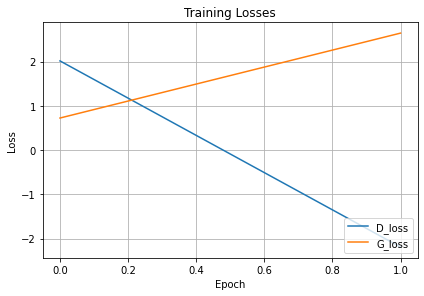

In [17]:
model.show_train_hist()

# Generating data

In [18]:
class election_GAN_GEN(object):
    def __init__(self,
                dim_height = None,
                dim_width = None,
                dim_z = None,
                num_class = None,
                batch_size = None,):
        
        # Definition Params:
        self.dim_height = dim_height    
        self.dim_width = dim_width  
        self.dim_z = dim_z    
        self.num_class = num_class      
        self.batch_size = batch_size  

        # Define Network Input:
        self.Z = tf.placeholder(tf.float32, shape=(None, 1, 1, self.dim_z))
        self.Y_label = tf.placeholder(tf.float32, shape=(None, 1, 1, self.num_class))

        # Network:
        self._GEN(self.Z, self.Y_label)

        # get the generated data
        with tf.variable_scope('object_cost_function', reuse=tf.AUTO_REUSE):
            self.call_GEN()
        
    def _GEN(self, Z, Y_label):            
        keep_prob_feed = 1
        isTrain=False 
        dim = 128
        
        with tf.variable_scope("GEN", reuse=False):
            # concat layer
            Z_ = tf.concat([Z, Y_label], 3)  #(batch_szie, 1, 1, dim_z + num_class)
            Z_ = tf.reshape(Z_, (-1, self.dim_z + self.num_class))        

            # FCN 
            hidden = tf.layers.dense(Z_, units = 2*2*3*dim)
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)
            hidden = tf.reshape(hidden, (-1, 2, 2, 3*dim)) 

            # CNN 1 
            hidden = tf.layers.conv2d_transpose(hidden, 2*dim, [3, 3], strides=(1, 2), padding='valid')
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)

            # CNN 2 
            hidden = tf.layers.conv2d_transpose(hidden, 1*dim, [3, 3], strides=(3, 3), padding='same')
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)     

            # CNN 3 
            hidden = tf.layers.conv2d_transpose(hidden, 1, [3, 3], strides=(2, 2), padding='same')         
            output = hidden

            return output     
    
    def call_GEN(self):
        self.fake_output = self._GEN(self.Z, self.Y_label)

    def GEN_model(self, path, iteration): 
    
        saver = tf.train.Saver()

        gpu_options = tf.GPUOptions(allow_growth=True)
        with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
            saver.restore(sess, tf.train.latest_checkpoint(path))      
            
            generated_3alt = []
            generated_4alt = []  
            
            for _ in range(iteration): 
                '''#############        Generator          #######################'''
                ############        num_alternative = 3      #######################
                z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   
                y_ = np.zeros([self.batch_size, 1]) + 0
                y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])

                output_g_alt3 = sess.run([self.fake_output], feed_dict={self.Z: z_, self.Y_label: y_label_})    
                output_g_alt3_ = np.array(output_g_alt3).reshape([self.batch_size, self.dim_height, self.dim_width])
                generated_3alt.append(output_g_alt3_)
                
                ############        num_alternative = 4      #######################
                z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   
                y_ = np.zeros([self.batch_size, 1]) + 1
                y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])

                output_g_alt4 = sess.run([self.fake_output], feed_dict={self.Z: z_, self.Y_label: y_label_})  
                output_g_alt4_ = np.array(output_g_alt4).reshape([self.batch_size, self.dim_height, self.dim_width])
                generated_4alt.append(output_g_alt4_)

            generated_3alt = np.array(generated_3alt).reshape([iteration*self.batch_size, self.dim_height, self.dim_width])
            generated_4alt = np.array(generated_4alt).reshape([iteration*self.batch_size, self.dim_height, self.dim_width])
                
            return generated_3alt, generated_4alt

In [19]:
tf.reset_default_graph()

In [20]:
generator = election_GAN_GEN(
                dim_height = dim_height,
                dim_width = dim_width,
                dim_z = dim_z,
                num_class = num_class,
                batch_size = batch_size)


shape[0]: number of generated data

shape[1], shape[2]: data size before resize back to original size

In [21]:
iteration_generator = 50
gen_alt3, gen_alt4 = generator.GEN_model(path = restore_path, 
                                         iteration = iteration_generator) #iteration: how many times generator is used?
print(gen_alt3.shape) 
print(gen_alt4.shape)

INFO:tensorflow:Restoring parameters from election_GAN/model_.ckpt
(2500, 24, 30)
(2500, 24, 30)


<Figure size 432x288 with 0 Axes>

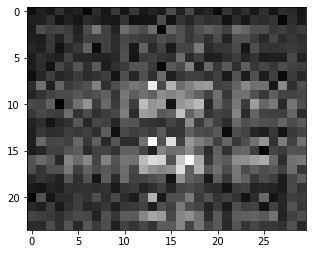

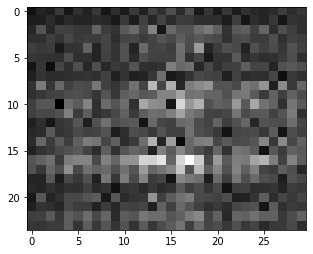

In [22]:
plt.figure(1)
fig, ax = plt.subplots(figsize=(5, 5))
ax.cla()
ax.imshow(np.reshape(gen_alt3[0], (dim_height, dim_width)), cmap='gray')

fig, ax = plt.subplots(figsize=(5, 5))
ax.cla()
ax.imshow(np.reshape(gen_alt4[0], (dim_height, dim_width)), cmap='gray')            
plt.show()

# Resize to original shpe & Save as CSV

In [24]:
img_size = np.math.factorial(6)
img_width = 30
img_height = 24
ori_size = np.math.factorial(3)

gen_alt3_ori = resize_to_ori(gen_alt3, img_size, img_width, img_height, ori_size, batch_size, iteration_generator)
gen_alt3_pd = pd.DataFrame(gen_alt3_ori, columns = ['ABC', 'ACB', 'BAC', 'BCA', 'CAB', 'CBA'])
print(gen_alt3_pd.shape)
gen_alt3_pd.head()

(2500, 6)


,ABC,ACB,BAC,BCA,CAB,CBA
0,0.047967,0.052468,0.102623,0.077700,0.092883,0.068956
1,0.042824,0.045081,0.088500,0.062508,0.077102,0.060780
2,0.039014,0.041422,0.083894,0.062264,0.075189,0.053789
3,0.042977,0.043172,0.086369,0.062150,0.080225,0.056160
4,0.047659,0.049378,0.092674,0.069921,0.082698,0.056301


In [25]:
# gen_alt3_pd.to_csv(generated_path + 'generated_atl3.csv')

In [26]:
img_size = np.math.factorial(6)
img_width = 30
img_height = 24
ori_size = np.math.factorial(4)

gen_alt4_ori = resize_to_ori(gen_alt4, img_size, img_width, img_height, ori_size, batch_size, iteration_generator)
gen_alt4_pd = pd.DataFrame(gen_alt4_ori, columns = ['ABCD', 'ACBD', 'BACD', 'BCAD', 'CABD', 'CBAD', 'DABC',
       'DACB', 'DBAC', 'DBCA', 'DCAB', 'DCBA', 'ADBC', 'ADCB', 'BDAC', 'BDCA',
       'CDAB', 'CDBA', 'ABDC', 'ACDB', 'BADC', 'BCDA', 'CADB', 'CBDA'])
print(gen_alt4_pd.shape)
gen_alt4_pd.head()

(2500, 24)


,ABCD,ACBD,BACD,BCAD,CABD,CBAD,DABC,DACB,DBAC,DBCA,...,BDAC,BDCA,CDAB,CDBA,ABDC,ACDB,BADC,BCDA,CADB,CBDA
0,0.026425,0.024765,0.061816,0.051633,0.053358,0.042280,0.049070,0.033234,0.084597,0.077996,...,0.078480,0.065638,0.130425,0.093457,0.062460,0.034821,0.054285,0.044731,0.076999,0.054766
1,0.022834,0.026503,0.060569,0.047345,0.048826,0.037074,0.047225,0.041563,0.095374,0.080740,...,0.077475,0.065737,0.118736,0.093364,0.058595,0.035742,0.055552,0.045612,0.073628,0.062392
2,0.027547,0.029678,0.066357,0.050623,0.051857,0.040148,0.055795,0.041479,0.098971,0.084410,...,0.089807,0.068682,0.132911,0.097236,0.062626,0.036629,0.054150,0.048649,0.078823,0.060524
3,0.026020,0.024871,0.065171,0.054840,0.050372,0.044552,0.043449,0.037521,0.091346,0.074878,...,0.074761,0.065733,0.115150,0.091849,0.054119,0.031248,0.049755,0.042492,0.071094,0.051340
4,0.025484,0.027012,0.059440,0.047506,0.050620,0.042423,0.045088,0.035070,0.091792,0.079066,...,0.076449,0.063285,0.117618,0.088294,0.056595,0.033740,0.051846,0.044567,0.074544,0.053946


In [27]:
# gen_alt4_pd.to_csv(generated_path + 'generated_atl4.csv')